# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is levearaging a working model's existing architecute and learned patterns for ou own problem.

In [6]:
!nvidia-smi

Thu Jun 15 20:23:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [7]:
# Get data (10% of 10 food classes from Food101)

import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-06-15 20:23:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.128, 173.194.194.128, 173.194.196.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   185MB/s    in 0.9s    

2023-06-15 20:23:18 (185 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [8]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent

## Creating data loaders (preparing the data)

In [9]:
# Setup data inputs

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print("Training images: ")
train_data = train_datagen.flow_from_directory(train_dir,
                                                target_size = IMAGE_SHAPE,
                                                batch_size = BATCH_SIZE,
                                                class_mode = 'categorical')
print("Testing images: ")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = 'categorical')

Training images: 
Found 750 images belonging to 10 classes.
Testing images: 
Found 2500 images belonging to 10 classes.


## Setting up callbacks

In [10]:
# Create TensorBoard callback (functionized)

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" +experiment_name +"/" + datetime.datetime.now().strftime("Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In [21]:
# Compare the following two models


# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"



In [12]:
# Import dependencies

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [27]:
def create_model(model_url, num_classes =10):
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])
  return model

### Creating ResNet TensorFlow Hub Feature extraction Hub

In [29]:
resnet_model = create_model(resnet_url,
                            num_classes=train_data.num_classes)

In [30]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [33]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

In [40]:
# Fit our ResNet model to the data
resnet_history = resnet_model.fit(train_data,
                                  epochs = 5,
                                  steps_per_epoch=len(train_data),
                                  validation_data = test_data,
                                  callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                           experiment_name= "resnet50v2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/Y0615-212155
Epoch 1/5
24/24 [==============================] - 21s 887ms/step - loss: 0.3187 - accuracy: 0.9347 - val_loss: 0.6890 - val_accuracy: 0.7712
Epoch 2/5
24/24 [==============================] - 19s 828ms/step - loss: 0.2662 - accuracy: 0.9560 - val_loss: 0.6561 - val_accuracy: 0.7924
Epoch 3/5
24/24 [==============================] - 20s 853ms/step - loss: 0.2207 - accuracy: 0.9653 - val_loss: 0.6420 - val_accuracy: 0.7948
Epoch 4/5
24/24 [==============================] - 20s 862ms/step - loss: 0.1900 - accuracy: 0.9787 - val_loss: 0.6549 - val_accuracy: 0.7824
Epoch 5/5
24/24 [==============================] - 20s 856ms/step - loss: 0.1653 - accuracy: 0.9827 - val_loss: 0.6413 - val_accuracy: 0.7916


In [35]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

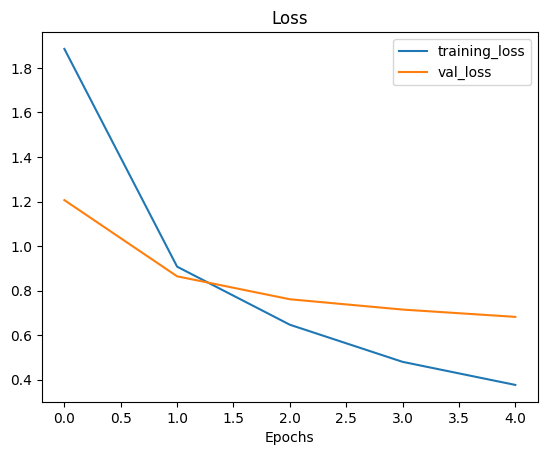

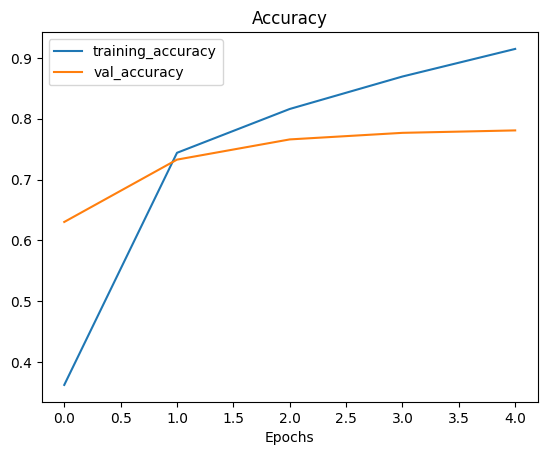

In [37]:

plot_loss_curves(resnet_history)

### Creating EfficientNetB0 TensorFlow Hub Feature Extraction model

In [39]:
efficientnet_model = create_model(model_url=efficientnet_url)

In [41]:
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics = ["accuracy"])

efficientnet_history = efficientnet_model.fit(train_data,
                                  epochs = 5,
                                  steps_per_epoch=len(train_data),
                                  validation_data = test_data,
                                  callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                           experiment_name= "efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/Y0615-212339
Epoch 1/5
24/24 [==============================] - 34s 929ms/step - loss: 1.8981 - accuracy: 0.4267 - val_loss: 1.3217 - val_accuracy: 0.7440
Epoch 2/5
24/24 [==============================] - 19s 808ms/step - loss: 1.0675 - accuracy: 0.7787 - val_loss: 0.8688 - val_accuracy: 0.8232
Epoch 3/5
24/24 [==============================] - 21s 906ms/step - loss: 0.7526 - accuracy: 0.8307 - val_loss: 0.6961 - val_accuracy: 0.8488
Epoch 4/5
24/24 [==============================] - 19s 806ms/step - loss: 0.6048 - accuracy: 0.8587 - val_loss: 0.6069 - val_accuracy: 0.8600
Epoch 5/5
24/24 [==============================] - 22s 935ms/step - loss: 0.5118 - accuracy: 0.8827 - val_loss: 0.5545 - val_accuracy: 0.8692


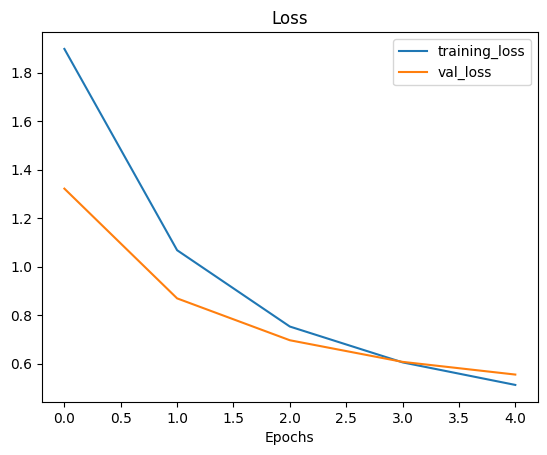

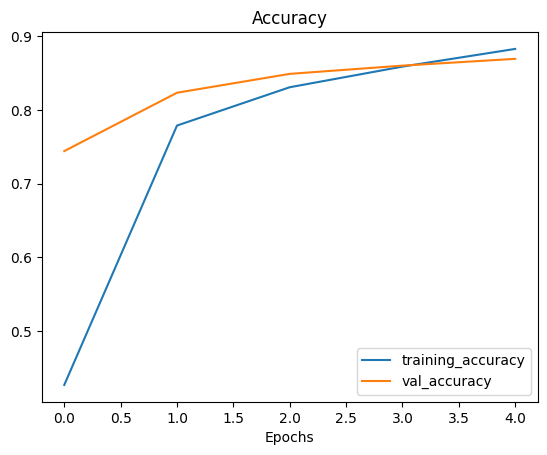

In [42]:
plot_loss_curves(efficientnet_history)

## Comparing our models results using TensorBoard

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
 --name "EfficientNetB0 vs ResNet50v2" \
 --description "Comparing 2 different TF Hubfeature extraction model architectures"\
 --one_shot

https://tensorboard.dev/experiment/IO52AoR8QMaq6GzHxRbDWg/